In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams.update({'figure.autolayout': True})

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score 

In [4]:
# pull data
df = pd.read_csv('conversion_project.csv')

In [5]:
# data frame
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [123]:
## check missing data
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [124]:
# initial explodation of the data
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.00000,316200.00000,316200.00000,316200.00000
mean,30.56986,0.68546,4.87297,0.03226
std,8.27180,0.46433,3.34110,0.17668
min,17.00000,0.00000,1.00000,0.00000
25%,24.00000,0.00000,2.00000,0.00000
50%,30.00000,1.00000,4.00000,0.00000
75%,36.00000,1.00000,7.00000,0.00000
max,123.00000,1.00000,29.00000,1.00000


## Findings from initial data exploration

Age has outliers. Will remove outliers that the age >=90.

In [125]:
data = df[df['age']< 90]

In [128]:
# recheck the data, and 2 outliers are removed. 
data.describe()

,age,new_user,total_pages_visited,converted
count,316198.00000,316198.00000,316198.00000,316198.00000
mean,30.56931,0.68547,4.87292,0.03225
std,8.26896,0.46433,3.34105,0.17667
min,17.00000,0.00000,1.00000,0.00000
25%,24.00000,0.00000,2.00000,0.00000
50%,30.00000,1.00000,4.00000,0.00000
75%,36.00000,1.00000,7.00000,0.00000
max,79.00000,1.00000,29.00000,1.00000


## More data exploration

In [11]:
pd.crosstab(data['country'], data['converted'])

converted,0,1
country,,
China,76500,102
Germany,12240,815
UK,45900,2549
US,171360,6732


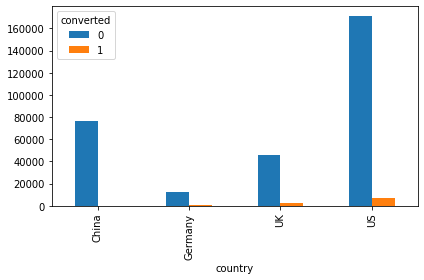

In [12]:
pd.crosstab(data['country'], data['converted']).plot.bar()

In [13]:
pd.crosstab(data['source'], data['converted'])

converted,0,1
source,,
Ads,85680,3059
Direct,70380,2040
Seo,149940,5099


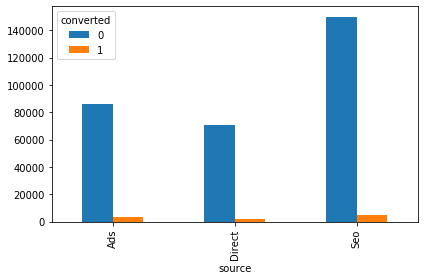

In [14]:
pd.crosstab(data['source'], data['converted']).plot.bar()

In [15]:
pd.crosstab(data['new_user'], data['converted'])

converted,0,1
new_user,,
0,92295,7159
1,213705,3039


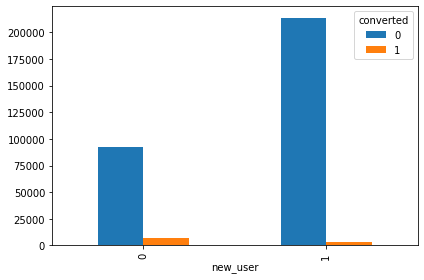

In [16]:
pd.crosstab(data['new_user'], data['converted']).plot.bar()

(array([1.28436e+05, 1.07615e+05, 5.31670e+04, 1.70820e+04, 4.23600e+03,
        3.26900e+03, 1.69200e+03, 5.89000e+02, 1.02000e+02, 1.00000e+01]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

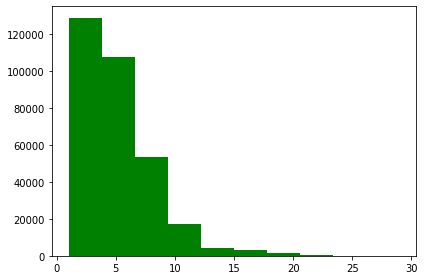

In [17]:
plt.hist(data['total_pages_visited'], color = 'green')

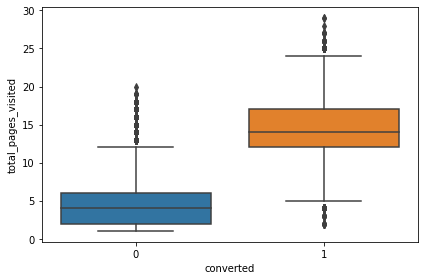

In [18]:
sns.boxplot(x=data['converted'], y=data['total_pages_visited'], data=df) 

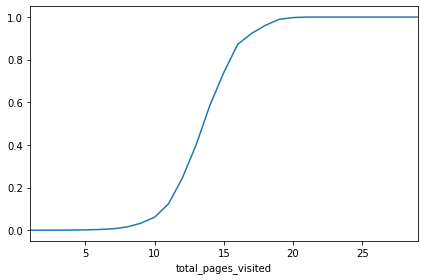

In [19]:
df.groupby(data['total_pages_visited'])['converted'].mean().plot()

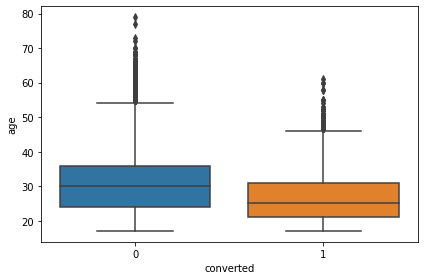

In [20]:
sns.boxplot(x=data['converted'], y=df['age'], data=df) 

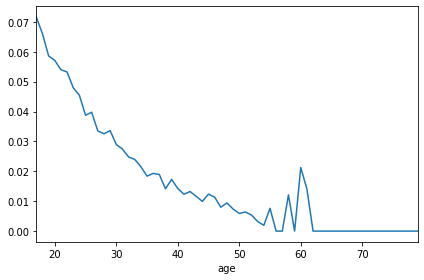

In [21]:
df.groupby(data['age'])['converted'].mean().plot()

## Findings from data exploration:
Age, total pages reviewed, and if new user both create variances on conversion rate. 

# Machine learning and modeling:
1. Logistic regression and random forest are widely used algorithms from sklearn for binary classificaiton problems. These two models are both conducted and compared.
2. Deep learning gains increasing usage in predictive modling. Therefore, a classification model using deep learning algorithm was built to compare the other two supervised machine learning models. 

In [22]:
# one hot encoding 'country'
ohe = OneHotEncoder(sparse = False)
ohe_country = pd.DataFrame(ohe.fit_transform(pd.DataFrame(data['country'])), columns= ohe.get_feature_names())
ohe_source = pd.DataFrame(ohe.fit_transform(pd.DataFrame(data['source'])), columns= ohe.get_feature_names())
data_encoded = pd.concat([data, ohe_country, ohe_source], axis=1)

In [23]:
data_encoded = data_encoded.dropna()

In [24]:
X = data_encoded.drop(['converted', 'country','source'], axis=1)
y = data_encoded['converted']

In [84]:
X.head()

,age,new_user,total_pages_visited,x0_China,x0_Germany,x0_UK,x0_US,x0_Ads,x0_Direct,x0_Seo
0,25.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23.0,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30.0,1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [129]:
## standardize the features. 
ss = StandardScaler()

In [130]:
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [131]:
## Logistic regression model
lgr = LogisticRegression(random_state=123)

lgr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
lgr.score(X_train, y_train)

0.9851442354320316

In [30]:
y_predict = lgr.predict(X_test)

In [132]:
## build a function for performance metrics
def metrics(y_true, y_pred):
    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('F1: ' + str(f1_score(y_true, y_pred)))
    print('\n')

In [32]:
metrics(y_test, y_predict)

Accuracy: 0.9856291667193766
Precision: 0.8463886063072228
Recall: 0.6661329063250601
F1: 0.7455197132616488




In [76]:
## Random Forest classification model, set up oob_score as True so that could use oob_score and accuracy on test set to examine overfitting issue
rf = RandomForestClassifier(n_estimators=100, warm_start=True, oob_score=True)

In [77]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=True)

In [140]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(y_train, rf.oob_decision_function_[:,1].round(), labels=[0, 1])),
"\n",
metrics(y_train, rf.oob_decision_function_[:,1].round())
)

Accuracy: 0.9833099301277267
Precision: 0.8003210272873195
Recall: 0.6475324675324675
F1: 0.7158650394831299


OOB accuracy is 0.9833099301277267 
 OOB Confusion Matrix 
         0     1
0  228203  1244
1    2714  4986 
 None


In [142]:
metrics(y_test, rf.predict(X_test))

Accuracy: 0.9838707637035257
Precision: 0.7978567949342426
Recall: 0.655724579663731
F1: 0.7198417930125247




From metrics on oob function and the test set, overfitting is not a concern.

In [80]:
print(pd.DataFrame(confusion_matrix(y_test, lgr.predict(X_test))))

       0     1
0  76249   302
1    834  1664


In [65]:
print(classification_report(y_test, lgr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     76551
         1.0       0.85      0.67      0.75      2498

    accuracy                           0.99     79049
   macro avg       0.92      0.83      0.87     79049
weighted avg       0.98      0.99      0.98     79049



In [66]:
print(pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test))))

       0     1
0  76142   409
1    870  1628


In [67]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     76551
         1.0       0.80      0.65      0.72      2498

    accuracy                           0.98     79049
   macro avg       0.89      0.82      0.85     79049
weighted avg       0.98      0.98      0.98     79049



In [163]:
## importance of features on train decision
print(pd.DataFrame(rf.feature_importances_, X.columns.T))

                          0
age                 0.12207
new_user            0.03963
total_pages_visited 0.81993
x0_China            0.00273
x0_Germany          0.00167
x0_UK               0.00231
x0_US               0.00230
x0_Ads              0.00307
x0_Direct           0.00307
x0_Seo              0.00321


OOB accuracy is 0.9832213774578636 
 OOB Confusion Matrix 
         0     1
0  228181  1266
1    2713  4987


In [71]:
rf.oob_score_

0.9832213774578636

In [164]:
## coefficients of features on target variable
print(pd.DataFrame(lgr.coef_, columns=X.columns).T)

                           0
age                 -0.62824
new_user            -0.80066
total_pages_visited  2.54414
x0_China            -0.13307
x0_Germany           0.04588
x0_UK                0.07161
x0_US                0.04460
x0_Ads              -0.00684
x0_Direct           -0.01589
x0_Seo               0.01951


In [90]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [91]:
print(tf.__version__)

2.1.0


In [102]:
# baseline model


model = keras.Sequential([
    keras.layers.Flatten(input_shape=(10,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, 
          y_train, 
          epochs=10, 
          batch_size=32,
          verbose=1, 
          validation_data=(X_test, y_test))

# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)

Train on 237147 samples, validate on 79049 samples
Epoch 1/10
237147/237147 [==============================] - 8s 33us/sample - loss: 0.0516 - accuracy: 0.9834 - val_loss: 0.0443 - val_accuracy: 0.9851
Epoch 2/10
237147/237147 [==============================] - 8s 33us/sample - loss: 0.0452 - accuracy: 0.9848 - val_loss: 0.0440 - val_accuracy: 0.9856
Epoch 3/10
237147/237147 [==============================] - 8s 33us/sample - loss: 0.0450 - accuracy: 0.9848 - val_loss: 0.0440 - val_accuracy: 0.9855
Epoch 4/10
237147/237147 [==============================] - 8s 33us/sample - loss: 0.0448 - accuracy: 0.9848 - val_loss: 0.0445 - val_accuracy: 0.9850
Epoch 5/10
237147/237147 [==============================] - 8s 32us/sample - loss: 0.0448 - accuracy: 0.9847 - val_loss: 0.0438 - val_accuracy: 0.9855
Epoch 6/10
237147/237147 [==============================] - 8s 32us/sample - loss: 0.0447 - accuracy: 0.9850 - val_loss: 0.0439 - val_accuracy: 0.9852
Epoch 7/10
237147/237147 [=================

In [103]:
dp_y_predict = model.predict(X_test)

In [112]:
np.set_printoptions(suppress=True)
print(dp_y_predict.round(5)) 

[[0.00003]
 [0.19477]
 [0.     ]
 ...
 [0.01318]
 [0.00018]
 [0.0003 ]]


In [117]:
dp_y_pred_new =(dp_y_predict>0.5).astype(int)

In [118]:
metrics(y_test, dp_y_pred_new)

Accuracy: 0.9855406140495135
Precision: 0.840623428858723
Recall: 0.6693354683746997
F1: 0.7452640962781367




In [119]:
print(confusion_matrix(y_test, dp_y_pred_new))

[[76234   317]
 [  826  1672]]


In [121]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(10,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.fit(X_train, 
          y_train, 
          epochs=10, 
          batch_size=8,
          verbose=1, 
          validation_data=(X_test, y_test))

Train on 237147 samples, validate on 79049 samples
Epoch 1/10
237147/237147 [==============================] - 33s 138us/sample - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.0441 - val_accuracy: 0.9854
Epoch 2/10
237147/237147 [==============================] - 32s 133us/sample - loss: 0.0454 - accuracy: 0.9846 - val_loss: 0.0440 - val_accuracy: 0.9855
Epoch 3/10
237147/237147 [==============================] - 31s 133us/sample - loss: 0.0453 - accuracy: 0.9848 - val_loss: 0.0443 - val_accuracy: 0.9853
Epoch 4/10
237147/237147 [==============================] - 32s 135us/sample - loss: 0.0452 - accuracy: 0.9848 - val_loss: 0.0444 - val_accuracy: 0.9855
Epoch 5/10
237147/237147 [==============================] - 44s 186us/sample - loss: 0.0450 - accuracy: 0.9849 - val_loss: 0.0440 - val_accuracy: 0.9853
Epoch 6/10
237147/237147 [==============================] - 33s 139us/sample - loss: 0.0450 - accuracy: 0.9850 - val_loss: 0.0444 - val_accuracy: 0.9854
Epoch 7/10
237147/237147 [=====

## Findings:
Comparing the performance of these three models, logistic regression model has a slightly higher performance than deep learning model, and random forest model. Nevertheless, the difference is too small and could ignore.

The coefficients from logistic regression model and the feature importances of the random forest model both showed that, the total pages reviewed explains a large proportion of variance of the conversion rate. It makes sense because if one customer wants to convert, this customer must review lots of pages. The total pages reviewd is also a variable that could not control or hardly improve.

The other three variables are country, if new user, and age.

Age has a negative coefficient of -0.6 on target variable, which means that the website product is more attractive to younger population.
New users has a -0.8 coefficient as well, which means the website is more attractive for existing users. Need to make more efforts on attracting and converting new users.
The other countries have more impact on conversion compared to China.
Sources from SOE has positive coefficient on conversion. Need to increase sources form SOE.


In [167]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(X_train, y_train)
  
#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=X.columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'